# Using PointNet for part segmentation of airplane parts

Ref: https://github.com/nikitakaraevv/pointnet/

In [2]:
%%capture 
import numpy as np

from tqdm import tqdm
import glob
import time


import torch
import torch.nn as nn

Here we build a custom dataset

the code is origiannly from:
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

In [3]:
from torch.utils.data import Dataset, DataLoader

import random

def read_pts(file):
    verts = np.genfromtxt(file)
    return verts

def read_seg(file):
    verts = np.genfromtxt(file, dtype= (int))
    return verts

def sub_sample(pcs, labels, k):    
    res1 = np.concatenate((pcs, np.reshape(labels, (labels.shape[0], 1))), axis= 1)
    res = np.asarray(random.choices(res1, weights=None, cum_weights=None, k=k))
    pcs = res[:, 0:-1]
    labels = res[:, -1]
    labels -= 1
    return pcs, labels

class AirplanePartSegmenatationDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, root_dir, transform=False):
        
        self.root_dir = root_dir
        self.files = []
        self.labels = []
        self.sample_size =  4000
        
        folders = glob.glob(root_dir + "/expert_verified/points_label")
        
        for folder in folders:
            img_labels = glob.glob(folder + "/*")
            self.labels += img_labels
            for img_label in img_labels:
                img_path = img_label.replace("/expert_verified/points_label", "/points")
                img_path = img_path.replace(".seg", ".pts")
                self.files.append(img_path) 
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        pts_path = self.files[idx]
        label_path = self.labels[idx]
        
        with open(pts_path, 'r') as f:
            pts = read_pts(f)
        with open(label_path, 'r') as f:  
            label = read_seg(f)
                    
        pts, label = sub_sample(pts, label, self.sample_size)
        
        return {'points': np.array(pts, dtype="float32"), 'labels': label.astype(int)}

Here we build data loader and train test the data using torch built in dataset and data loaders, Size of the validation data is  approximately 600 samples while the size of train data is 2000 samples.

In [4]:
train_dataset = AirplanePartSegmenatationDataset("../input/airplane-part-segmenation/02691156")

# split the dataset in train and test set
indices = torch.randperm(len(train_dataset)).tolist()
train_data = torch.utils.data.Subset(train_dataset, indices[:2000])
val_data = torch.utils.data.Subset(train_dataset, indices[2000:])

# define training and validation data loaders
train_dataloader = torch.utils.data.DataLoader(
        train_data, batch_size=32, shuffle=True, num_workers=0)

val_dataloader = torch.utils.data.DataLoader(
        val_data, batch_size=32, shuffle=False, num_workers=0)

Here is one sample of the dataset with which shows an airplane with the segmented parts

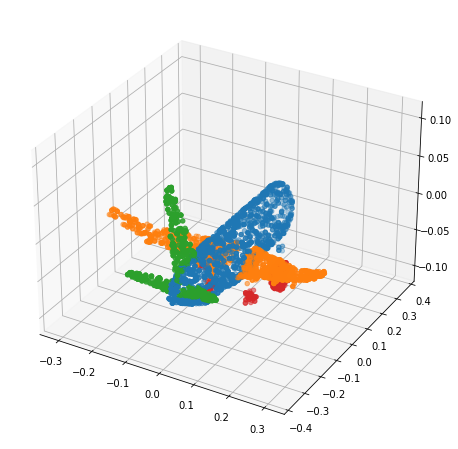

In [5]:
def plot_sample(sample_points, sample_labels, cal_preds=False, preds=None):
    sample_points = sample_points.numpy()
    
    if cal_preds:
        sample_labels = preds
    else:
        sample_labels = sample_labels.numpy()

    x = sample_points[:, 0]
    y = sample_points[:, 1]
    z = sample_points[:, 2]
    labels_color = []
    for label in sample_labels:
        if label == 0:
            labels_color.append('#1f77b4')
        elif label == 1:
            labels_color.append('#ff7f0e')
        elif label == 2:
            labels_color.append('#2ca02c')
        elif label == 3:
            labels_color.append('#d62728')
    
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import proj3d

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(z,x, y, c=labels_color)
    plt.show()
    
sample = next(iter(train_dataloader))
plot_sample(sample['points'][0], sample['labels'][0])

In [6]:
import numpy as np
import torch

def accuracy(scores, labels):

    num_classes = scores.size(-2)

    predictions = torch.max(scores, dim=-2).indices

    accuracies = []

    accuracy_mask = predictions == labels
    for label in range(num_classes):
        label_mask = labels == label
        per_class_accuracy = (accuracy_mask & label_mask).float().sum()
        per_class_accuracy /= label_mask.float().sum()
        accuracies.append(per_class_accuracy.cpu().item())
        
    accuracies.append(accuracy_mask.float().mean().cpu().item())
    return accuracies

def intersection_over_union(scores, labels):
    
    num_classes = scores.size(-2)

    predictions = torch.max(scores, dim=-2).indices

    ious = []

    for label in range(num_classes):
        pred_mask = predictions == label
        labels_mask = labels == label
        iou = (pred_mask & labels_mask).float().sum() / (pred_mask | labels_mask).float().sum()
        ious.append(iou.cpu().item())
    ious.append(np.nanmean(ious))
    return ious

# Pointnet model architecture

In [7]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

class Tnet(nn.Module):
   def __init__(self, k=3):
      super().__init__()
      self.k=k
      self.conv1 = nn.Conv1d(k,64,1)
      self.conv2 = nn.Conv1d(64,128,1)
      self.conv3 = nn.Conv1d(128,1024,1)
      self.fc1 = nn.Linear(1024,512)
      self.fc2 = nn.Linear(512,256)
      self.fc3 = nn.Linear(256,k*k)

      self.bn1 = nn.BatchNorm1d(64)
      self.bn2 = nn.BatchNorm1d(128)
      self.bn3 = nn.BatchNorm1d(1024)
      self.bn4 = nn.BatchNorm1d(512)
      self.bn5 = nn.BatchNorm1d(256)
       

   def forward(self, input):
      # input.shape == (bs,n,3)
      bs = input.size(0)
      xb = F.relu(self.bn1(self.conv1(input)))
      xb = F.relu(self.bn2(self.conv2(xb)))
      xb = F.relu(self.bn3(self.conv3(xb)))
      pool = nn.MaxPool1d(xb.size(-1))(xb)
      flat = nn.Flatten(1)(pool)
      xb = F.relu(self.bn4(self.fc1(flat)))
      xb = F.relu(self.bn5(self.fc2(xb)))
      
      #initialize as identity
      init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
      if xb.is_cuda:
        init=init.cuda()
      matrix = self.fc3(xb).view(-1,self.k,self.k) + init
      return matrix


class Transform(nn.Module):
   def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=128)
        
        self.fc1 = nn.Conv1d(3,64,1)
        self.fc2 = nn.Conv1d(64,128,1) 
        self.fc3 = nn.Conv1d(128,128,1)
        self.fc4 = nn.Conv1d(128,512,1)
        self.fc5 = nn.Conv1d(512,2048,1)

        
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(2048)

   def forward(self, input):
        n_pts = input.size()[2]
        matrix3x3 = self.input_transform(input)
        xb = torch.bmm(torch.transpose(input,1,2), matrix3x3).transpose(1,2)
        outs = []
        
        out1 = F.relu(self.bn1(self.fc1(xb)))
        outs.append(out1)
        out2 = F.relu(self.bn2(self.fc2(out1)))
        outs.append(out2)
        out3 = F.relu(self.bn3(self.fc3(out2)))
        outs.append(out3)
        matrix128x128 = self.feature_transform(out3)
        
        out4 = torch.bmm(torch.transpose(out3,1,2), matrix128x128).transpose(1,2) 
        outs.append(out4)
        out5 = F.relu(self.bn4(self.fc4(out4)))
        outs.append(out5)
       
        xb = self.bn5(self.fc5(out5))
        
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        out6 = nn.Flatten(1)(xb).repeat(n_pts,1,1).transpose(0,2).transpose(0,1)#.repeat(1, 1, n_pts)
        outs.append(out6)
        
        
        return outs, matrix3x3, matrix128x128


class PointNetSeg(nn.Module):
    def __init__(self, num_classes = 4):
        super().__init__()
        self.transform = Transform()

        self.fc1 = nn.Conv1d(3008,256,1) 
        self.fc2 = nn.Conv1d(256,256,1) 
        self.fc3 = nn.Conv1d(256,128,1) 
        self.fc4 = nn.Conv1d(128,num_classes,1) 
        

        self.bn1 = nn.BatchNorm1d(256)
        self.bn2 = nn.BatchNorm1d(256)
        
        self.bn3 = nn.BatchNorm1d(128)
        self.bn4 = nn.BatchNorm1d(num_classes)
        
        self.logsoftmax = nn.LogSoftmax(dim=1)
        

    def forward(self, input):
        inputs, matrix3x3, matrix128x128 = self.transform(input)
        
        stack = torch.cat(inputs,1)
        
        xb = F.relu(self.bn1(self.fc1(stack)))
       
        xb = F.relu(self.bn2(self.fc2(xb)))
    
        xb = F.relu(self.bn3(self.fc3(xb)))
        
        output = F.relu(self.bn4(self.fc4(xb)))
        
        return self.logsoftmax(output), matrix3x3, matrix128x128
    
    
def pointnetloss(outputs, labels, m3x3, m128x128, alpha = 0.0001):
    #print(outputs.shape, labels.shape)
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id128x128 = torch.eye(128, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id128x128=id128x128.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff128x128 = id128x128-torch.bmm(m128x128,m128x128.transpose(1,2))
    loss = criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff128x128)) / float(bs)
    return loss
    
#ref: https://github.com/nikitakaraevv/pointnet/

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
pointnet = PointNetSeg()
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)
pointnet.to(device)

PointNetSeg(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(128, 64, kernel_size

# Model Training

In [9]:
def train(model, train_loader, val_loader,  epochs=8):
    for epoch in range(epochs):
        tick = time.time()
        print('Epoch ', epoch+1, ':')
        model.train()
        train_loss = 0.0
        for i, data in enumerate(tqdm(train_loader), 0):
            
            inputs, labels = data['points'].to(device), data['labels'].to(device)
            
            labels = labels.long()
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs.transpose(1,2))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        print('Train Loss: ', train_loss/len(train_loader))
        evaluate_per_epoch(model, train_loader, val_loader)
        tock = time.time()
        print('Time Elapsed: ', tock-tick, ' seconds')
        
    torch.save(model.state_dict(), "./final_model")
        
    
def evaluate_per_epoch(model, train_loader, val_loader):
            
    model.eval()
    train_correct = train_total = 0
    val_correct = val_total = 0
    train_ious, val_ious = [], []
        
    with torch.no_grad():
        for data in train_loader:
            inputs, labels = data['points'].to(device), data['labels'].to(device)
            outputs, __, __ = model(inputs.transpose(1,2))
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0) * labels.size(1) ##
            train_correct += (predicted == labels).sum().item()
            train_ious.append(intersection_over_union(outputs, labels))
    
    train_acc = train_correct / train_total
    
    print('Train mIOU: ', np.mean(train_ious))
    print('Train Accuracy: ',train_acc)
            
    # validation
    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data['points'].to(device), data['labels'].to(device)
            outputs, __, __ = model(inputs.transpose(1,2))
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0) * labels.size(1)
            val_correct += (predicted == labels).sum().item()
            val_ious.append(intersection_over_union(outputs, labels))
    val_acc = val_correct / val_total
    print('Valid mIOU: ', np.mean(val_ious))
    print('Valid Accuracy: ', val_acc)

In [10]:
train(pointnet, train_dataloader, val_dataloader)

Epoch  1 :


100%|██████████| 63/63 [01:44<00:00,  1.67s/it]


Train Loss:  0.9670393750781104
Train mIOU:  0.4744706563503733
Train Accuracy:  0.689969125
Valid mIOU:  0.4705178235996176
Valid Accuracy:  0.6846536231884058
Time Elapsed:  210.68154072761536  seconds
Epoch  2 :


100%|██████████| 63/63 [01:33<00:00,  1.49s/it]


Train Loss:  0.6678256032958864
Train mIOU:  0.7487861638267835
Train Accuracy:  0.873906625
Valid mIOU:  0.746443125334653
Valid Accuracy:  0.8713601449275362
Time Elapsed:  193.4104859828949  seconds
Epoch  3 :


100%|██████████| 63/63 [01:31<00:00,  1.44s/it]


Train Loss:  0.605946333635421
Train mIOU:  0.7678297542863421
Train Accuracy:  0.883215
Valid mIOU:  0.7646321559494192
Valid Accuracy:  0.8800942028985507
Time Elapsed:  190.44903945922852  seconds
Epoch  4 :


100%|██████████| 63/63 [01:31<00:00,  1.45s/it]


Train Loss:  0.5583050941664075
Train mIOU:  0.7830026887712025
Train Accuracy:  0.89222425
Valid mIOU:  0.7798135849562559
Valid Accuracy:  0.8885851449275363
Time Elapsed:  192.41882586479187  seconds
Epoch  5 :


100%|██████████| 63/63 [01:33<00:00,  1.48s/it]


Train Loss:  0.524332247556202
Train mIOU:  0.795312046531647
Train Accuracy:  0.898032625
Valid mIOU:  0.7892420522191308
Valid Accuracy:  0.8938340579710145
Time Elapsed:  194.98336672782898  seconds
Epoch  6 :


100%|██████████| 63/63 [01:33<00:00,  1.49s/it]


Train Loss:  0.49349653011276606
Train mIOU:  0.8014879602761495
Train Accuracy:  0.899588
Valid mIOU:  0.7963248145851222
Valid Accuracy:  0.8954246376811594
Time Elapsed:  194.9854462146759  seconds
Epoch  7 :


100%|██████████| 63/63 [01:33<00:00,  1.48s/it]


Train Loss:  0.46573118558005683
Train mIOU:  0.7929805268843969
Train Accuracy:  0.893081125
Valid mIOU:  0.787194965237921
Valid Accuracy:  0.8889123188405798
Time Elapsed:  194.5639545917511  seconds
Epoch  8 :


100%|██████████| 63/63 [01:32<00:00,  1.48s/it]


Train Loss:  0.4424118200937907
Train mIOU:  0.7917561642234288
Train Accuracy:  0.89208475
Valid mIOU:  0.7917403456839648
Valid Accuracy:  0.891156884057971
Time Elapsed:  193.69027948379517  seconds


Now we plug the model weights and use it on a random sample to visualize the predictions

In [11]:
%%capture 
pointnet4pred = PointNetSeg()
pointnet4pred.load_state_dict(torch.load("./final_model"))
pointnet4pred.eval()

## Actual labels

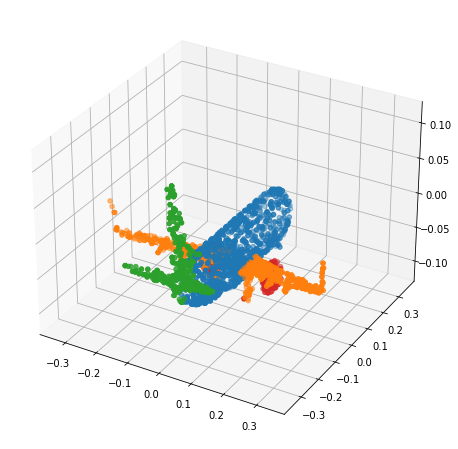

In [13]:
plot_sample(sample['points'][0], sample['labels'][0])

## Predictions

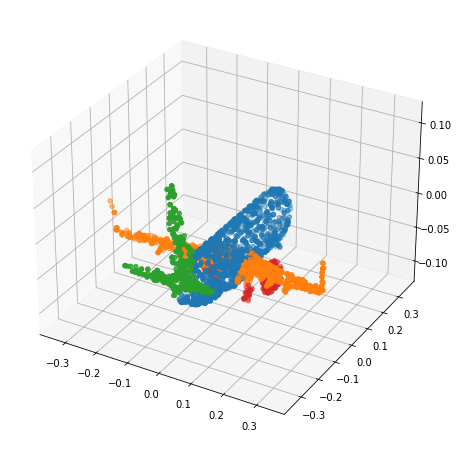

In [12]:
sample = next(iter(val_dataloader))
pred = pointnet4pred(sample['points'].transpose(1,2))
preds = np.array(torch.argmax(pred[0],1))
plot_sample(sample['points'][0], sample['labels'][0], cal_preds=True, preds=preds[0])